In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 

from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read wheat and weather data

In [50]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather = pd.read_csv("data/features/era_features.csv")

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv = x_y_cv.loc[x_y_cv["year"] < 2017].reset_index(drop=True) # Leave test set aside
x_y_cv = x_y_cv.loc[:, [c for c in x_y_cv.columns if ("_8" not in c)]]

### 2. Detrend national wheat yield
.. using all previous years to estimate the slope (data since 69 is available)

#### 2.1 Estimate slope and bias for each year's trend correction

In [51]:
# dictionary that stores for each year the slope and bias estimated from the previous years
years_to_params = {}
# iterate over all years in x_y_cv dataset (1993-2016)
for year in x_y_cv["year"].unique().tolist():
    # initialize key
    years_to_params[year] = {"slope":np.nan, "bias":np.nan}
    # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
    year_range = wheat.loc[wheat["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
    slope, bias= np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias
# print example
years_to_params[2010]

{'slope': 40.186997705965986, 'bias': -77958.053590407}

#### 2.2 Predict yield level for each year based on trend function

.. and visualize the trend estimates compared to observed yield

379.99


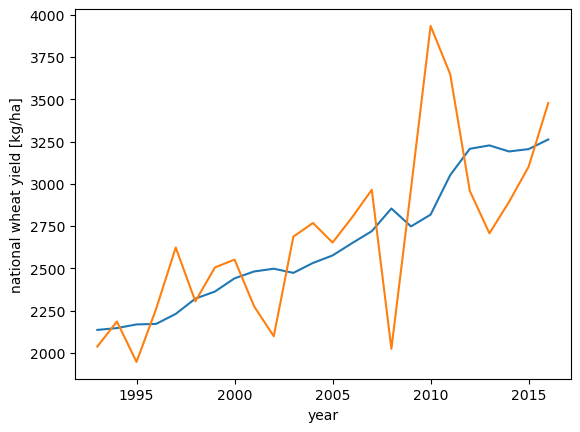

In [52]:
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)
    
plt.plot(x_y_cv["year"].unique().tolist(), trend_estimated)
plt.plot(x_y_cv["year"].unique().tolist(), x_y_cv["yield [kg/ha]"])
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))
plt.show()

#### 2.3. Adjust the trend using multiplicative decomposition

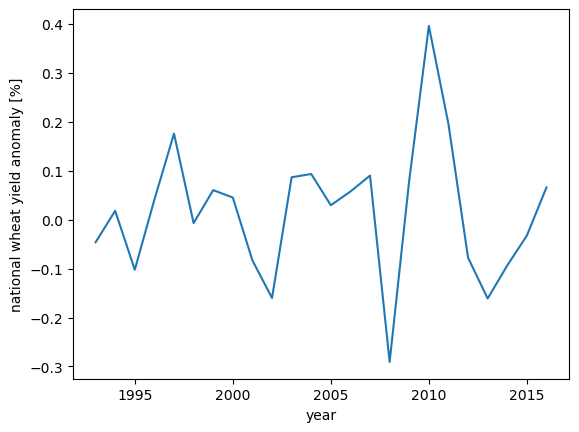

In [53]:
x_y_cv["yield_trend [kg/ha]"] = trend_estimated
x_y_cv["yield anomaly [%]"] = (x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"])/x_y_cv["yield_trend [kg/ha]"]

plt.plot(x_y_cv["year"], x_y_cv["yield anomaly [%]"]);
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.show()

### 3. Identify relevant locations for weather features

- there are more than 100 municipalities with tmean and rainfall data
- we perform LOYO-CV to select the municipalities that best explain national wheat yield

In [62]:
# obtain the municipalities from the column name; santa fe san cristobal to replace NANs
municipalities = list(set([c.split("_")[1] if c not in ['year', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]'] else 'santa fe san cristobal' for c in x_y_cv.columns]))

In [63]:
for m in municipalities:
    for no_of_features in list(range(1,10)):
        
        # filter by current municipality
        x_y_cv_temp = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] == m] + ["yield anomaly [%]"]]
        
        # feature-target split
        X = x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if ("rain" in c) or ("tmean" in c)]]
        y = x_y_cv_temp["yield anomaly [%]"]
        X_columns = X.columns
        
        # scale features
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)
        
        # store features and target in variables for better readability
        X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
        X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
        
        # basis expansion to linear model
        X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9", "tt_10", "tt_11"])
        X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9", "rr_10", "rr_11"])
        X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9", "rt_10", "rt_11"])
        
        # merge to feature dataframe
        X = (X.merge(X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True))
        
        # remove correlated features
        cor_matrix = X.corr().abs().round(2)
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
        X = X.drop(to_drop, axis=1)
        
        #for i in range(0,X.shape[1]):
        #    print(pearsonr(np.array(X).transpose()[i], y)[0])
        #    print(X.columns[i])
        
        # pipeline object for regression model
        pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
        
        # Perform LOOCV and obtain predictions
        loo = LeaveOneOut()
        y_pred = cross_val_predict(pipeline, X, y, cv=loo)

        # Calculate metrics
        rmse = np.round(100*mse(y_pred, y, squared=False), 1)
        meanabserr = np.round(100*mae(y_pred, y), 1)
        r = np.round(pearsonr(y_pred, y)[0], 2)

        # print metrics if they are good
        if r > 0.45:
            print("rmse is {}, MAE is {}, and pearson's r is {} for area {} with {} features".format(rmse, meanabserr, r, m, no_of_features))

rmse is 11.5, MAE is 9.0, and pearson's r is 0.53 for area buenos aires coronel pringles with 1 features
rmse is 10.8, MAE is 9.0, and pearson's r is 0.6 for area buenos aires hipolito yrigoyen with 1 features
rmse is 12.1, MAE is 8.9, and pearson's r is 0.53 for area buenos aires coronel dorrego with 1 features
rmse is 11.7, MAE is 9.3, and pearson's r is 0.5 for area buenos aires coronel dorrego with 3 features
rmse is 11.5, MAE is 8.8, and pearson's r is 0.52 for area buenos aires saavedra with 1 features
rmse is 11.8, MAE is 9.3, and pearson's r is 0.49 for area buenos aires saavedra with 2 features
rmse is 11.8, MAE is 9.1, and pearson's r is 0.5 for area buenos aires saavedra with 3 features
rmse is 11.8, MAE is 9.2, and pearson's r is 0.5 for area buenos aires tornquist with 1 features
rmse is 11.9, MAE is 9.2, and pearson's r is 0.48 for area buenos aires tornquist with 2 features
rmse is 12.0, MAE is 9.1, and pearson's r is 0.47 for area buenos aires tornquist with 3 features


**The best performance comes from buenos aires - [coronel dorrego, hipolpito yrigoyen, coronel pringles, coronel suarez, bahia blance, saavedra]**

**the furthest away are corronel dorrego and hipolito yrigoyen, hence we will filter for these two**

The hindcast data needs bias-adjustment for these two locations, hence we store a filtered ERA5 for later use:

In [20]:
era_preprocessed = pd.read_csv("data/ERA5/era5_preprocessed.csv")
era_preprocessed = era_preprocessed.loc[era_preprocessed["name"].isin(["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"])].reset_index(drop=True)

era_preprocessed.to_csv("nmme/data/era_filtered_locations.csv", index=False)
era_preprocessed.to_csv("c3s/data/era_filtered_locations.csv", index=False)
era_preprocessed.to_csv("clik-apcc/data/era_filtered_locations.csv", index=False)

### 4. Filter features 

.. to come only from buenos aires coronel dorrego and hipolpito yrigoyen

In [118]:
selected_areas = ["buenos aires villarino",  "buenos aires hipolito yrigoyen"]
x_y_cv_filtered = (x_y_cv
                   .loc[:, 
                        [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] in selected_areas] + ["yield anomaly [%]", "yield [kg/ha]", "year"]])

x_y_cv_filtered.columns = [c.replace("buenos aires ", "") if "buenos aires" in c else c for c in x_y_cv_filtered.columns]
x_y_cv_filtered.head()

,rain_hipolito yrigoyen_9,rain_hipolito yrigoyen_10,rain_hipolito yrigoyen_11,rain_villarino_9,rain_villarino_10,rain_villarino_11,tmean_hipolito yrigoyen_9,tmean_hipolito yrigoyen_10,tmean_hipolito yrigoyen_11,tmean_villarino_9,tmean_villarino_10,tmean_villarino_11,yield anomaly [%],yield [kg/ha],year
0,0.002687,0.002157,0.005082,0.000658,0.002037,0.002259,11.611024,16.041256,17.662613,12.046294,15.772928,17.793005,-0.046171,2037.439151,1993
1,0.001586,0.002564,0.001845,0.001093,0.001208,0.000981,12.882020,14.715967,19.764100,12.773536,14.695823,20.792565,0.018138,2185.741998,1994
2,0.001148,0.002388,0.004076,0.000225,0.001777,0.002020,13.288871,15.503959,19.738954,12.830177,15.147516,19.268950,-0.102265,1946.759707,1995
3,0.001189,0.003135,0.003330,0.000798,0.002469,0.001912,12.625015,16.642875,19.933778,12.200146,16.190346,20.703568,0.040968,2260.470320,1996
4,0.001448,0.006382,0.004226,0.001536,0.002311,0.001956,11.807031,14.851108,17.689280,11.142988,14.756868,18.196613,0.175913,2623.252920,1997


### 5. Train national model

rmse is 0.0881, MAE is 0.0731, and pearson's r is 0.76


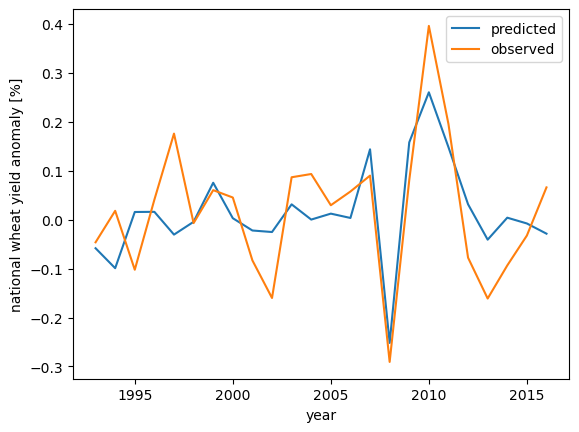

In [119]:
# feature-target split
X = x_y_cv_filtered.loc[:, [c for c in x_y_cv_filtered.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv_filtered["yield anomaly [%]"]
X_columns = X.columns

# scale features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

# store features and target in variables for better readability
X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]

# basis expansion to linear model
X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b"])
X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b"])
X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b"])

# merge to feature dataframe
X = (X.merge(X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True))

# remove correlated features
cor_matrix = X.corr().abs().round(2)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
X = X.drop(to_drop, axis=1)

#for i in range(0, X.shape[1]):
#    print("{}: {}".format(X.columns[i], np.round(pearsonr(np.array(X).transpose()[i], y)[0], 2)))
    
# pipeline object for regression model
pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=2)), ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

# Calculate metrics
rmse = np.round(mse(y, y_pred, squared=False), 4)
meanabserr = np.round(mae(y, y_pred), 4)
r = np.round(pearsonr(y, y_pred)[0], 2)

print("rmse is {}, MAE is {}, and pearson's r is {}".format(rmse, meanabserr, r))

plt.plot(x_y_cv_filtered["year"], y_pred, label="predicted");
plt.plot(x_y_cv_filtered["year"], y, label="observed");
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.legend();

### 6. Express as absolute yield forecast

.. by applying the inverse of the yield correction to the yield anomaly estimations

9.0


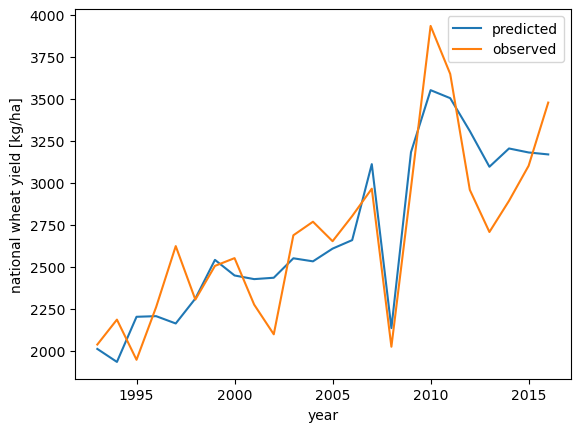

In [120]:
z = x_y_cv_filtered["year"].apply(lambda x: years_to_params[x]["slope"] * x + years_to_params[x]["bias"])

plt.plot(x_y_cv_filtered["year"], y_pred * z + z, label="predicted");
plt.plot(x_y_cv_filtered["year"], x_y_cv_filtered["yield [kg/ha]"], label="observed");
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")
plt.legend();

print(np.round(100 * np.mean(mse(y_pred * z + z, x_y_cv_filtered["yield [kg/ha]"], squared=False)/x_y_cv_filtered["yield [kg/ha]"]), 2))

In [10]:
x_y_cv_filtered = x_y_cv_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield [kg/ha]", "yield anomaly [%]"]).reset_index(drop=False)

### 7. Export datasets

In [11]:
x_y_cv_filtered.to_csv("data/features/era_features_and_target.csv", index=False)